# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Advanced-Sections: Homework 1 - Transfer Learning




**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
import os
import pathlib
working_dir = pathlib.Path().absolute()
# Uncomment the line below to help debug if the path to included images don't show
print(working_dir)
os.chdir(working_dir)

/jupyteruser/11425259/hw4


<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit. (Exception - you may skip the cells where you train neural networks, running the cells which load previously saved weights instead. However, **don't delete/overwrite the output that model.fit produced during training!**)

**Names of person you have worked with goes here:**
<br><BR>

<hr style="height:2pt">

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import os
# For colab: Import the TF V2 through this magic command
# %tensorflow_version 2.x 
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

#import keras
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import Image

# Check the Version of the Tensor Flow. It should be the version 2
print(tf.__version__)

2.0.0


<div class="theme"> Overview </div> 


**How to use existing models for transfer learning:**
Transfer learning is a Machine Learning method where we use the knowledge gained while solving a problem to solve another problem. For instance, when the training data is too small to train a deep network, we can load a pre-trained network and then fine-tuning a few of its parameters by using our small training set.
In this homework you will be engaged with two usefull applications of transfer learning. (a) Train a deep network with a small dataset. (b) Improve the feature extraction of a pre-train deep network. In particular, the aim of the homework is:
- Learn the idea of transfer learning through a simple classification example
- Build  new networks by using pre-trained models. Combine  pre-trained layers with new layers, and train specific layers.
- Get good  performance of image classification and feature extraction by training with small datasets.


The task of this homework is to design a network for classifying and extracting features for two different categories:  dogs and flowers.  The pre-trained model that  will be used is the *MobileNet* which is trained in 1000 categories with 1000 images per category. Although this pre-trained model classifies and extract features from 1000 categories pretty well, there are some other categories that the pre-trained MobileNet does not perform very well. In this homework, we will improve the performance, namely the classification and the feature extraction abilities of the MobileNet on those categories. 

----------


<div class='exercise'><b> Question 1: Load and inspect the pre-trained MobileNet  [40pts total] </b></div>


In this question, we have to load the pre-train the MobileNet. Then use the images and perfrom some classifications. Check whether the MobileNet classifies well and whether it is not. Afterwards, you need to make a deeper investigation. In particular, explore the feature maps extracted by the MobileNet. In this task you need to use the Principal Component Analysis method (PCA) to visualize the abstract feature maps space. 

**1.1. [10pts]**  Load a pre-trained MobileNet and inspect its performance in some of the images from the given `trainData`, or `testData`, or `pcaData` sets (these are new data for the pretrained MobileNet). Is the performance similar for all the  categories?


Set the directory where the dataset are located with the name `pathFolder`

In [11]:
#your code here
pathFolder = 'data209/'

Check that the pathFolder is correct by showing the following image

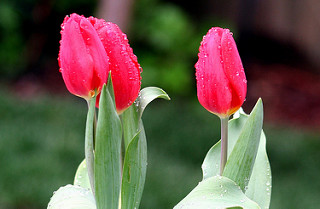

In [12]:
Image(filename= pathFolder + 'trainData/tulips/100930342_92e8746431_n.jpg')

Load the pre-train MobileNet trained in the `imagenet` dataset

In [4]:
#your code here
mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet')

Inspect the MobileNet architecture and define the image size as `IMG_SIZE` and the input shape as `IMG_SHAPE`

In [6]:
#your code here
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [5]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

**Three helper functions**

`prepare_image`: A function to prepare the images for the MobileNet. Input shape: (1, 224, 224, 3)

In [15]:
def prepare_image(img_path, img_size = 224):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

`mobileClassifier`: A helper function for doing the classification by using MobileNet

In [16]:
def mobileClassifier(imagePath, pathFolder=pathFolder, mobile=mobile):
    imagePathFull = pathFolder + imagePath
    preprocessed_image = prepare_image(imagePathFull)
    # Use mobileNet to classify the image
    predictions = mobile.predict(preprocessed_image)
    results = imagenet_utils.decode_predictions(predictions)
#print(results)
    return results

`Prepare the data`

Load the data into the ImageDataGenerator. You might want to use  data augmentation:

 https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/ 


In [13]:
# this is a function to avoid reading secret directory. You might also need it later
filter_hidden = lambda my_list: [x for x in my_list if not x.startswith('.')]


train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                                 horizontal_flip=True, 
                                                 rotation_range=45, 
#                                                 zoom_range=[0.8,1.0]
                                ) 

test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 


# TRAINING set
pathTrain = pathFolder + 'trainData/'
listGroupsTrain = filter_hidden(os.listdir(pathTrain)) # the directory path

# TESTING set
pathTest = pathFolder + 'testData/'
listGroupsTest = filter_hidden(os.listdir(pathTest)) # the directory path

# Load the data into the ImageDataGenerator
train_generator=train_datagen.flow_from_directory(pathTrain,
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True, 
                                                 classes=listGroupsTrain)


test_generator=test_datagen.flow_from_directory(pathTest,
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=False, 
                                                 classes=listGroupsTrain)

Found 843 images belonging to 5 classes.
Found 104 images belonging to 5 classes.


Classify some of the images. Choose images from different categories

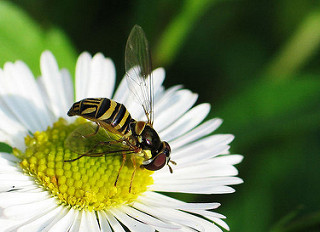

[[('n02206856', 'bee', 0.6906521),
  ('n11939491', 'daisy', 0.3047455),
  ('n02190166', 'fly', 0.0032878807),
  ('n02276258', 'admiral', 0.0004989182),
  ('n02281787', 'lycaenid', 0.0001323923)]]

In [17]:
#your code here
display(Image(filename= pathFolder + 'trainData/daisy/5547758_eea9edfd54_n.jpg', height=224, width=224))
mobileClassifier('trainData/daisy/5547758_eea9edfd54_n.jpg')

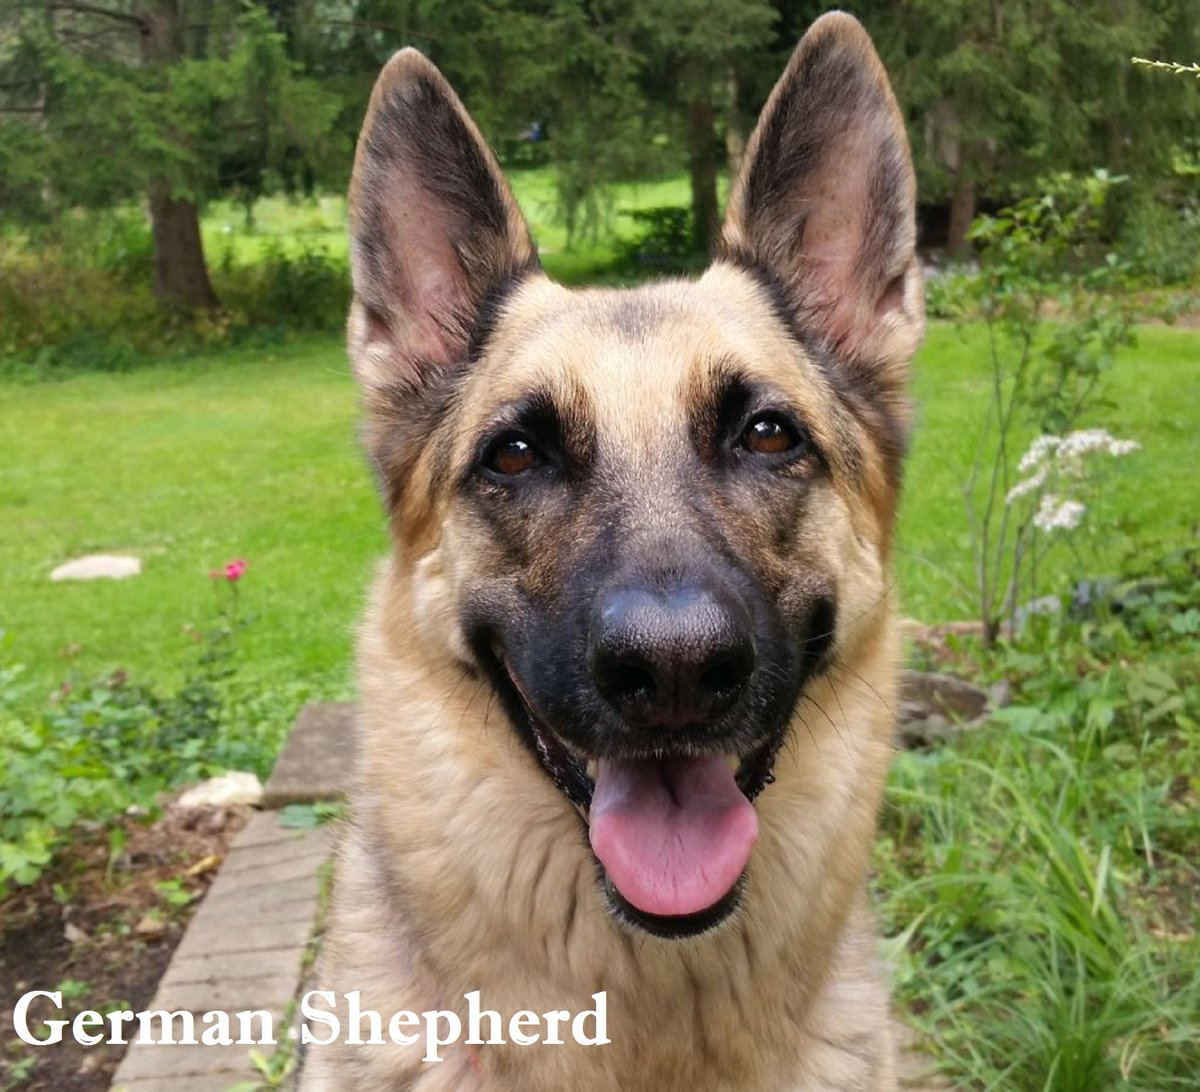

[[('n02106662', 'German_shepherd', 0.99727976),
  ('n02105162', 'malinois', 0.0027147485),
  ('n02091467', 'Norwegian_elkhound', 1.7166918e-06),
  ('n02116738', 'African_hunting_dog', 1.493915e-06),
  ('n02114712', 'red_wolf', 6.2165986e-07)]]

In [18]:
#your code here
display(Image(filename= pathFolder + 'trainData/German_Shepherd/1.DFWpzTSXcAEll7j.jpg', height=224, width=224))
mobileClassifier('trainData/German_Shepherd/1.DFWpzTSXcAEll7j.jpg')

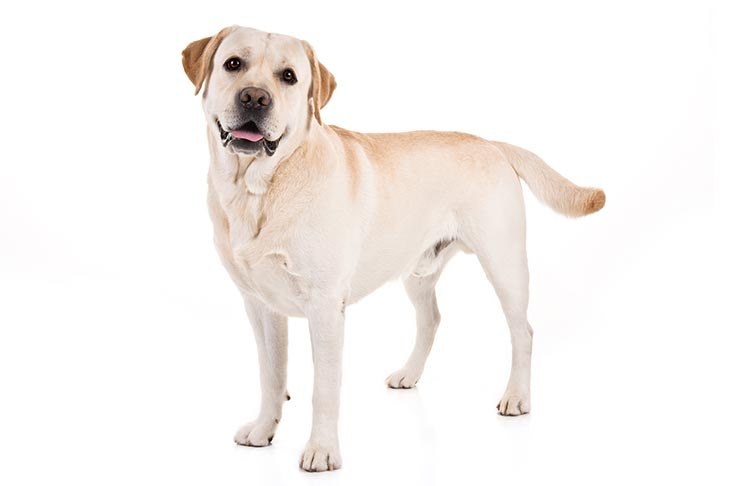

[[('n02099712', 'Labrador_retriever', 0.73073715),
  ('n02087394', 'Rhodesian_ridgeback', 0.03984368),
  ('n02092339', 'Weimaraner', 0.033590093),
  ('n02109047', 'Great_Dane', 0.028944712),
  ('n02110341', 'dalmatian', 0.022403585)]]

In [19]:
#your code here
display(Image(filename= pathFolder + 'trainData/labrador/1.Labrador-Retriever-On-White-01.jpg', height=224, width=224))
mobileClassifier('trainData/labrador/1.Labrador-Retriever-On-White-01.jpg')

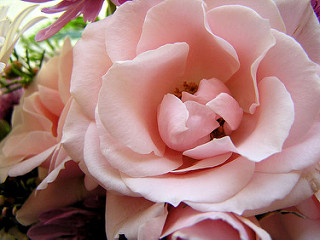

[[('n01914609', 'sea_anemone', 0.24263678),
  ('n13044778', 'earthstar', 0.11826978),
  ('n02219486', 'ant', 0.10142754),
  ('n13052670', 'hen-of-the-woods', 0.08705136),
  ('n07734744', 'mushroom', 0.060725935)]]

In [20]:
#your code here
display(Image(filename= pathFolder + 'trainData/rose/rose.jpg', height=224, width=224))
mobileClassifier('trainData/rose/rose.jpg')

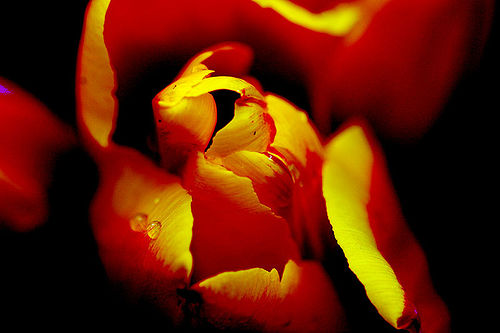

[[('n02607072', 'anemone_fish', 0.80860335),
  ('n03590841', "jack-o'-lantern", 0.049734414),
  ('n12620546', 'hip', 0.031514112),
  ('n07747607', 'orange', 0.017663287),
  ('n01443537', 'goldfish', 0.013207484)]]

In [21]:
#your code here
display(Image(filename= pathFolder + 'trainData/tulips/10791227_7168491604.jpg', height=224, width=224))
mobileClassifier('trainData/tulips/10791227_7168491604.jpg')

Make some comments

#### Your comments here:


The model seems to be doing pretty well in classifying the animals, but struggles in classifying the flowers. Tulips, Rose, and Daisy are all wrongly classfied.


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1.1
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>correct
</span></div></div>

**1.2. [15pts]** Explore the feature maps extracted by the pre-train MobileNet. In particular, extract the features that MobileNet learns for three images, one from each category of dogs and flowers.
 
First, prepare the two images from each category

In [22]:
#your code here
X = [prepare_image(pathFolder+'trainData/tulips/10791227_7168491604.jpg'), #flower1 -> tulip
     prepare_image(pathFolder+'trainData/rose/rose.jpg'), #flower2 -> rose
     prepare_image(pathFolder+'trainData/German_Shepherd/1.DFWpzTSXcAEll7j.jpg'), #dog1 -> German_Shepherd
     prepare_image(pathFolder+'trainData/labrador/1.Labrador-Retriever-On-White-01.jpg') #dog2 -> Labrador
    ]

Inspect the first convolution layer: `conv1`. Exctract and plot the first five features maps of each image.

Hint: Load only up to the first convolution layer. Use `summary()` to check the name of the layer.


In [23]:
def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Actual Image of flower1 (tulip):



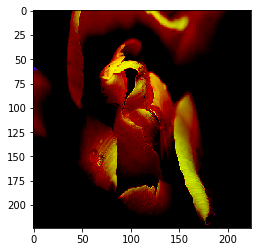


Feature Maps for Layer conv1 for image of flower1 (tulip)



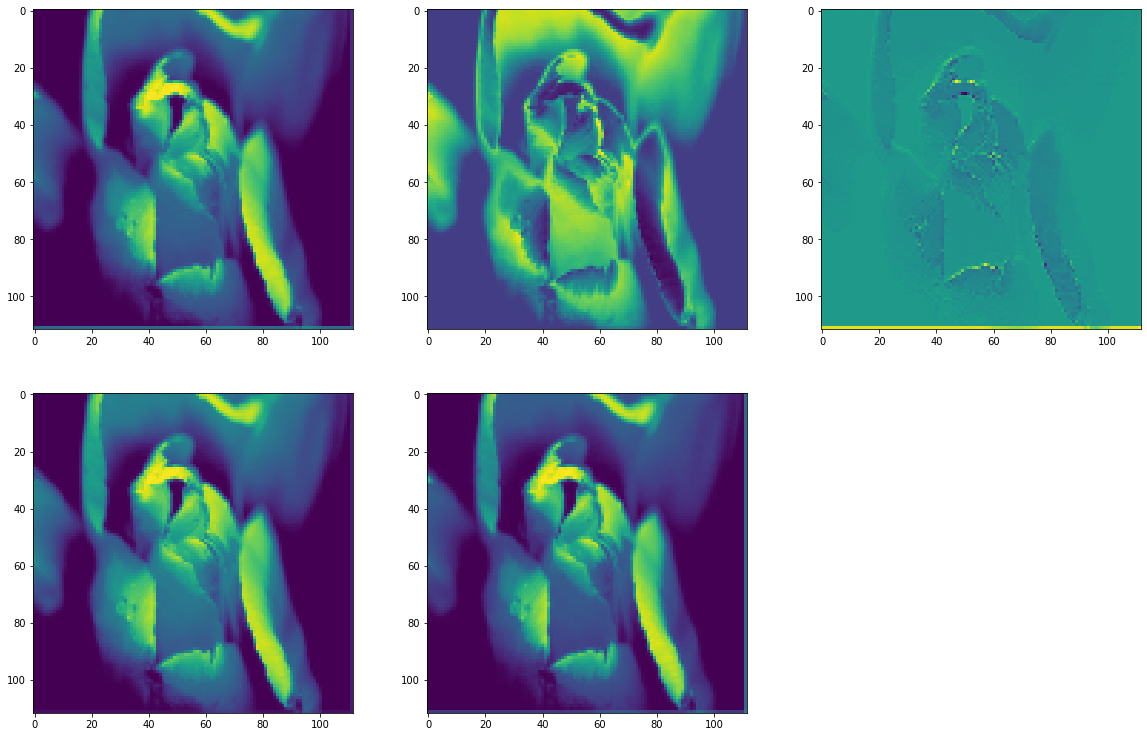

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Actual Image of flower2 (rose):



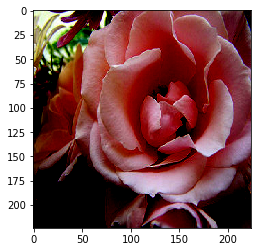


Feature Maps for Layer conv1 for image of flower2 (rose)



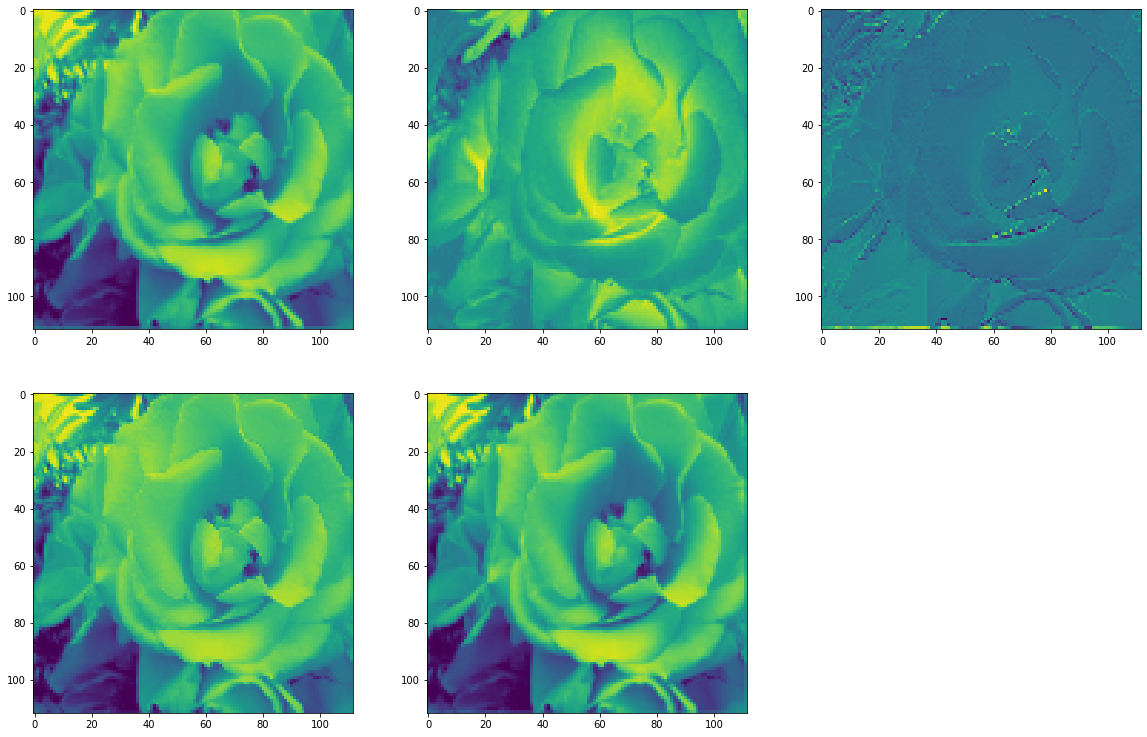

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Actual Image of dog1 (German_Shepherd):



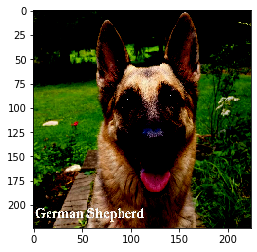


Feature Maps for Layer conv1 for image of dog1 (German_Shepherd)



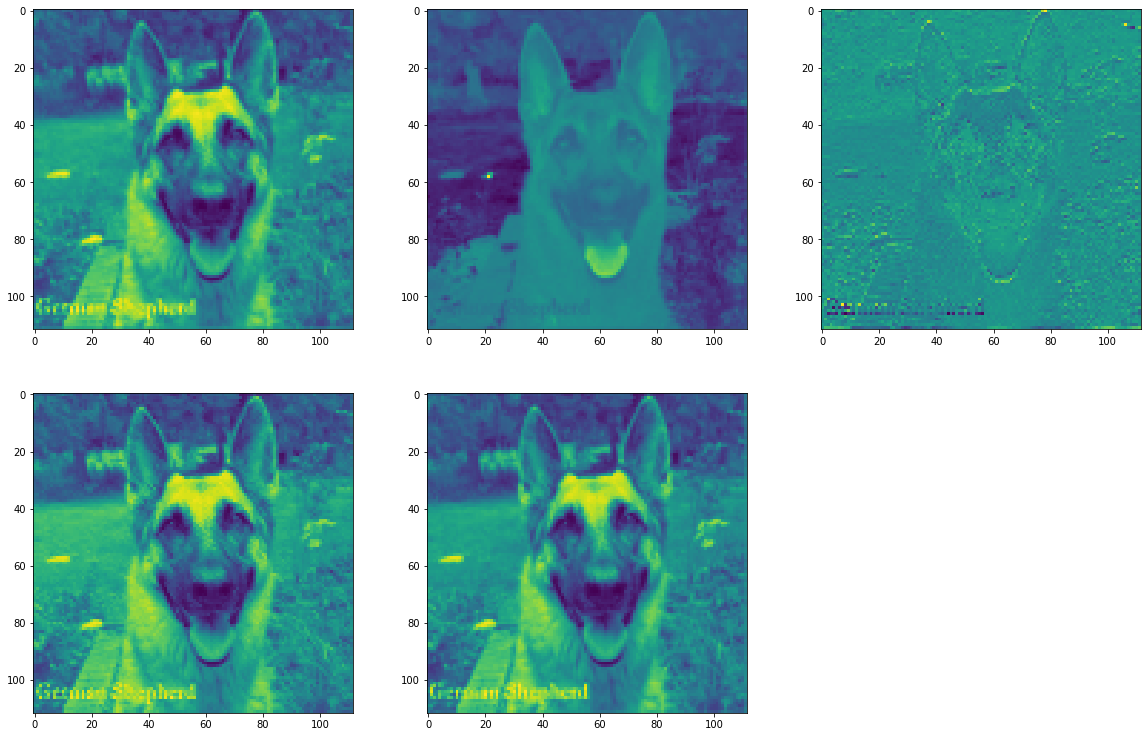

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Actual Image of dog2(Labrador):



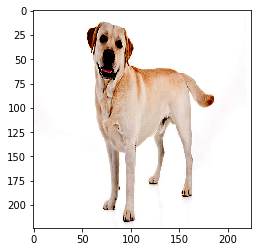


Feature Maps for Layer conv1 for image of dog2(Labrador)



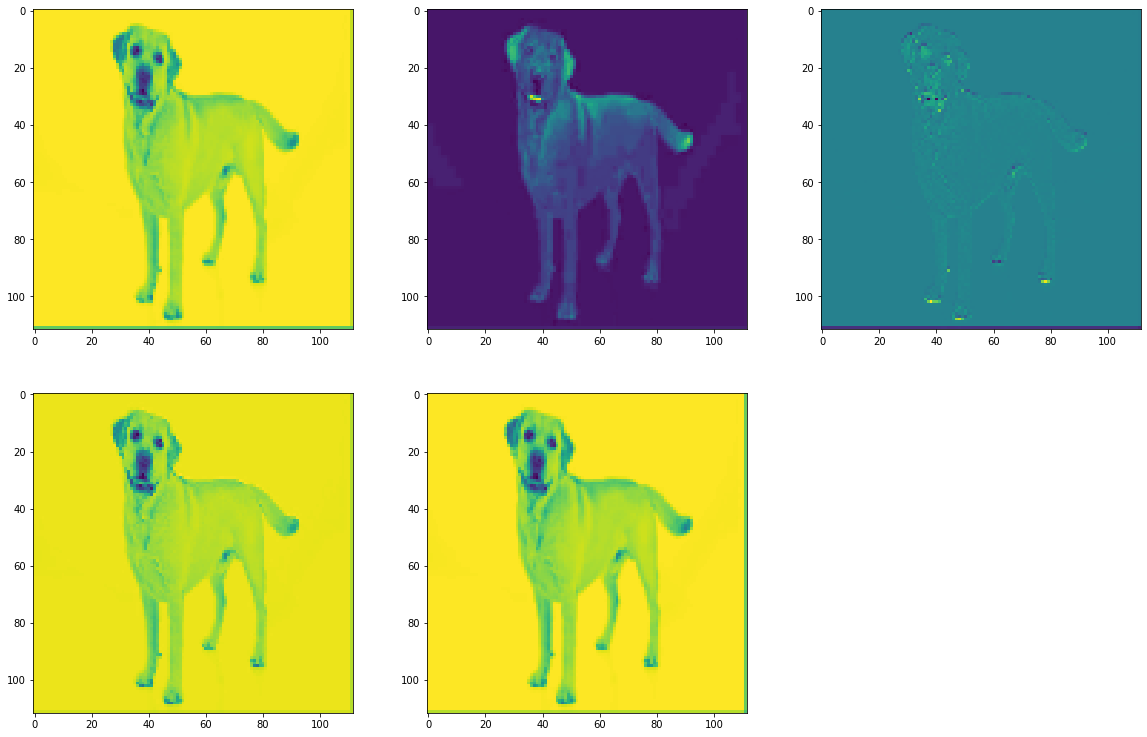

In [24]:
layer_dict = dict([(layer.name, layer) for layer in mobile.layers])
layer_name = 'conv1'

# model = Model(inputs=mobile.inputs, outputs=layer_dict[layer_name].output)

label = ['flower1 (tulip)', 'flower2 (rose)','dog1 (German_Shepherd)', 'dog2(Labrador)' ]
layer = list(layer_dict.keys()).index(layer_name)

for i in range(len(X)):
#     prediction = model.predict(X[i])
    feature_maps = get_feature_maps(mobile, layer, X[i][0])[:5,:,:]

    print("\nActual Image of {}:\n".format(label[i]))
    plt.imshow(X[i][0])
    plt.show()

    print("\nFeature Maps for Layer {} for image of {}\n".format(layer_name, label[i]))

    plt.figure(figsize=(20,20))
    for i in range(5):
        plt.subplot(3,3,i+1)
        plt.imshow(feature_maps[i,:,:], cmap='viridis')
    plt.show()

Inpsect the last 2D convolution layer: `conv_pw_13`. Exctract and plot the first five features maps of each image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Actual Image of flower1 (tulip):



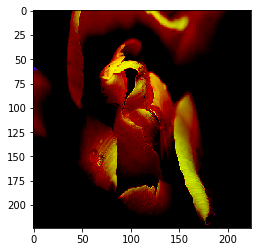


Feature Maps for Layer conv_pw_13 for image of flower1 (tulip)



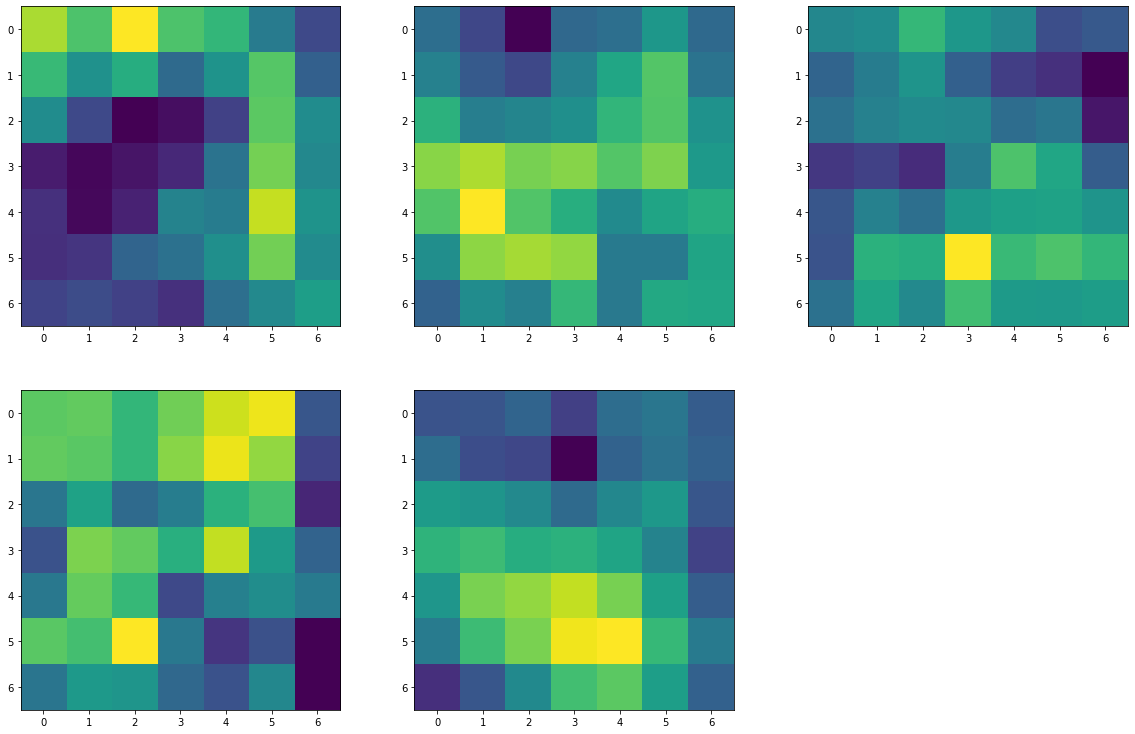


Actual Image of flower2 (rose):



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


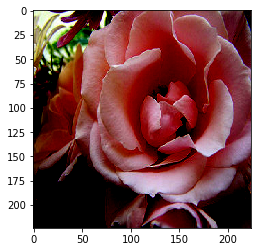


Feature Maps for Layer conv_pw_13 for image of flower2 (rose)



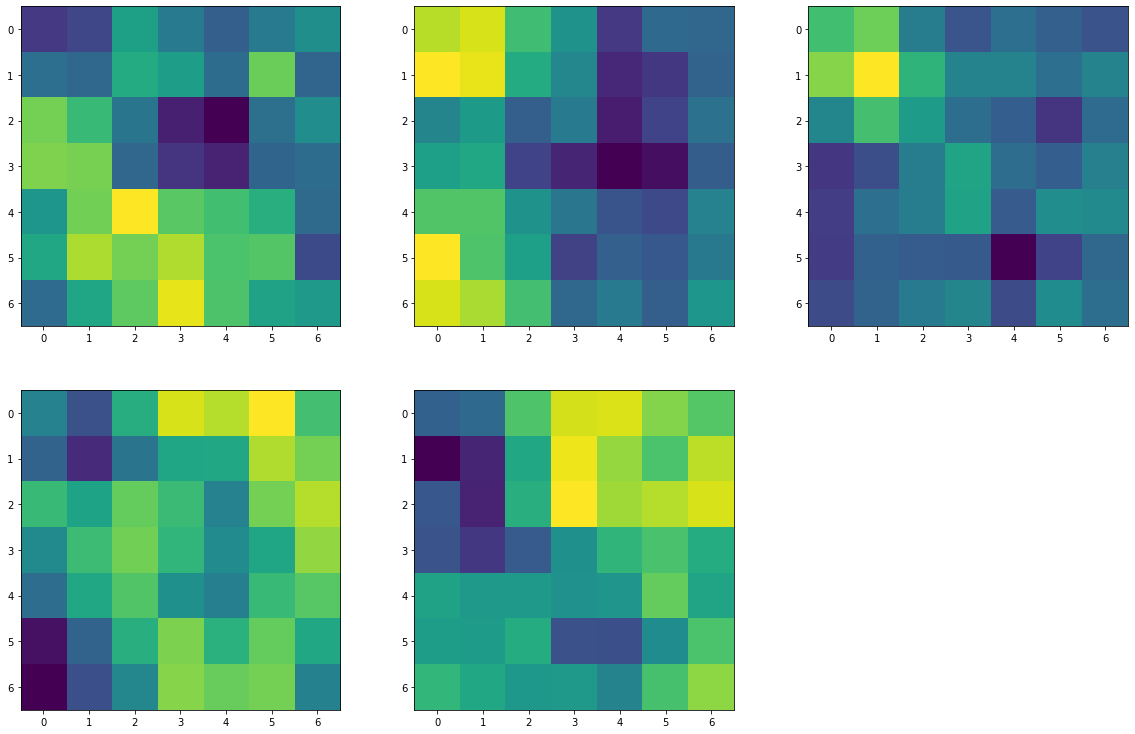

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Actual Image of dog1 (German_Shepherd):



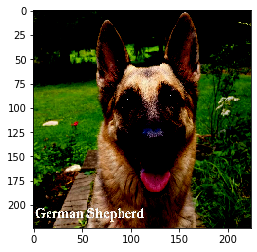


Feature Maps for Layer conv_pw_13 for image of dog1 (German_Shepherd)



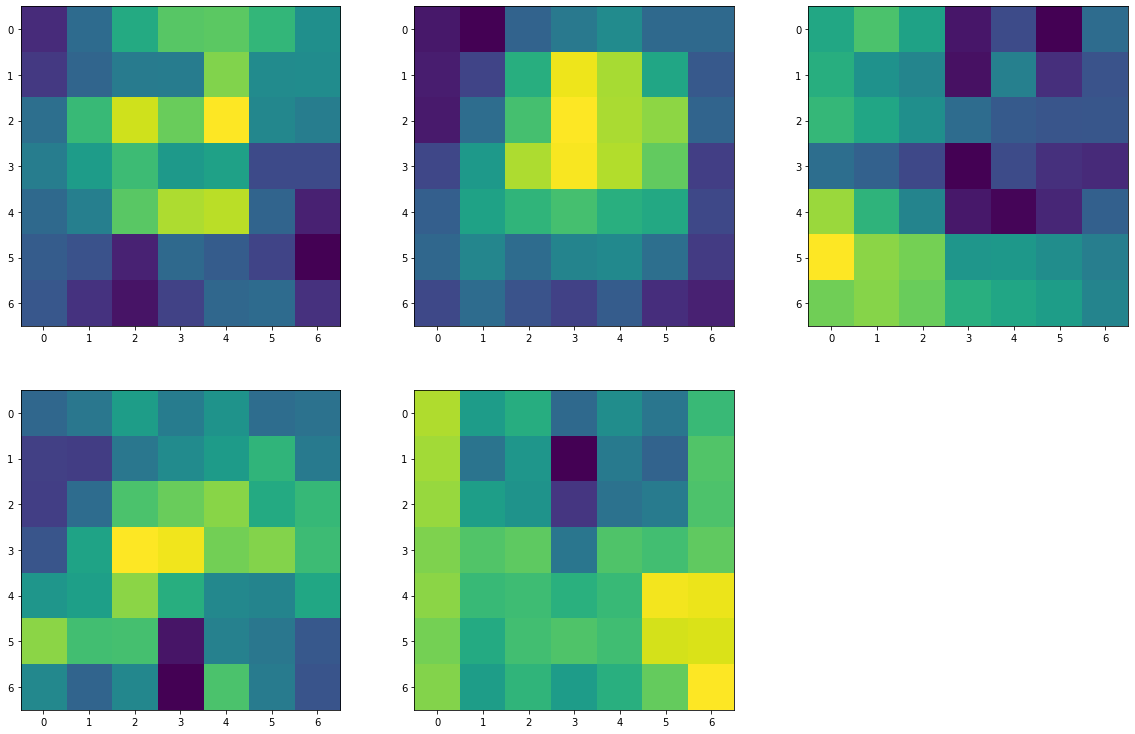

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Actual Image of dog2(Labrador):



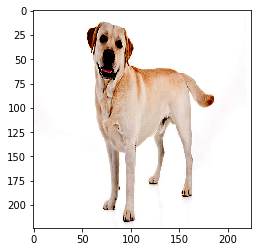


Feature Maps for Layer conv_pw_13 for image of dog2(Labrador)



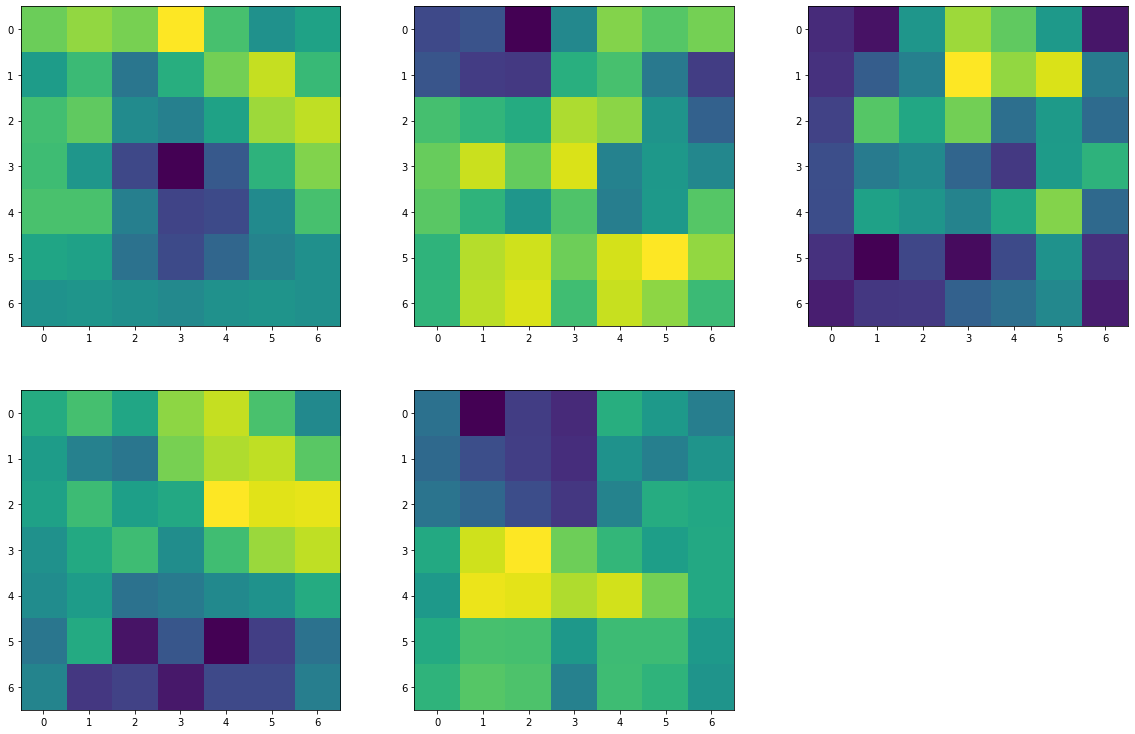

In [19]:
layer_dict = dict([(layer.name, layer) for layer in mobile.layers])
layer_name = 'conv_pw_13'

# model = Model(inputs=mobile.inputs, outputs=layer_dict[layer_name].output)

label = ['flower1 (tulip)', 'flower2 (rose)','dog1 (German_Shepherd)', 'dog2(Labrador)' ]
layer = list(layer_dict.keys()).index(layer_name)

for i in range(len(X)):
#     prediction = model.predict(X[i])
    feature_maps = get_feature_maps(mobile, layer, X[i][0])[:5,:,:]

    print("\nActual Image of {}:\n".format(label[i]))
    plt.imshow(X[i][0])
    plt.show()

    print("\nFeature Maps for Layer {} for image of {}\n".format(layer_name, label[i]))

    plt.figure(figsize=(20,20))
    for i in range(5):
        plt.subplot(3,3,i+1)
        plt.imshow(feature_maps[i,:,:], cmap='viridis')
    plt.show()

Can we draw any conclusions or understand anything from these feature maps? Obviously no. It is a very abstract representation. We can further investigate the feature maps by using **Principal Component Analysis (PCA)** method.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1.2
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>correct
</span></div></div>

**1.3. [15pts]** Use PCA to study the extracted feature maps. In particular, perform a PCA transform for the extracted from the last convolution layer features.

To save some time you might use only 20 images per category. These data are store at `pcaData`.


Define the layer from which we  extract the features

In [25]:
#your code here
layer = list(layer_dict.keys()).index('conv_pw_13')

Two intermedia steps: (A)  Count the total images and the categories of the dataset that is located in the `pcaData` directory. (B)  Prepare the data for the PCA and assign the associate name of category of each image

In [26]:
import pandas as pd
# Count the total images and the categories of the dataset that is located in the pcaData directory.
pathPCA = pathFolder + 'pcaData/'
listGroupsPCA = filter_hidden(os.listdir(pathPCA)) # the directory path
images = {}
X_pca = pd.DataFrame([])
totalImages = 0
for i in listGroupsPCA:
    path_images = pathPCA + i + '/'
    images[i] = filter_hidden(os.listdir(path_images))
    print('{} images for {}'.format(len(images[i]),i))
    totalImages += len(images[i])
    for j in images[i]:
        x = pd.Series(get_feature_maps(mobile, layer, prepare_image(path_images+j)[0]).flatten(),name=i)
        X_pca = X_pca.append(x)
print('Total number of images: {}'.format(totalImages))

20 images for German_Shepherd
20 images for labrador
20 images for tulips
20 images for daisy
20 images for rose
Total number of images: 100


Perform PCA transform and keep  onlythe first two principal components

In [27]:
X_pca = X_pca.reset_index()
X_pca = X_pca.rename(columns = {'index':'group'})

In [28]:
X_pca.head()

,group,0,1,2,3,4,5,6,7,8,...,50166,50167,50168,50169,50170,50171,50172,50173,50174,50175
0,German_Shepherd,-0.697548,-0.151683,-0.348087,-0.644270,-0.925943,-0.748203,-0.626896,-0.698227,0.548359,...,0.054446,0.034116,-0.353067,0.535434,0.459683,0.565953,0.344153,0.095837,0.424536,-0.403786
1,German_Shepherd,-0.537556,-0.598303,-0.085481,0.109895,0.167472,-0.139126,-0.491004,-0.752436,-0.669397,...,1.015068,0.598072,0.784857,0.354440,0.815370,0.891703,1.227095,0.954202,0.831712,0.357470
2,German_Shepherd,-0.890550,-0.707274,-0.594458,-0.449854,-0.990276,-1.102173,-1.718400,-1.287816,-1.416519,...,0.141296,0.810524,0.796783,0.701887,0.960600,1.103086,0.817377,0.492282,0.557285,0.285867
3,German_Shepherd,-0.888465,-0.763026,-0.892426,-0.700559,-0.745140,-0.895363,-1.185158,-1.052857,-0.436350,...,0.850718,0.590017,-0.238907,0.077138,-0.014444,0.306359,0.479116,0.476834,0.401481,-0.351543
4,German_Shepherd,-0.542449,-0.709905,0.016012,-0.174308,-0.067491,-0.468200,-0.686358,-0.801450,-0.455790,...,0.179367,0.409722,0.536741,0.301268,0.464640,0.287349,0.037910,-0.082985,0.335465,0.372852


In [29]:
model_pca = PCA(2).fit(X_pca.drop('group',axis=1))
pca_sample = pd.DataFrame(model_pca.transform(X_pca.drop('group',axis=1)), columns = ['principal component 1', 'principal component 2'])
pca_sample = pd.concat([pca_sample, X_pca['group']], axis = 1)


Plot the results obtained by PCA transform. Use different color/symbol to represent each of the categories.

In [ ]:
# listGroupsPCA

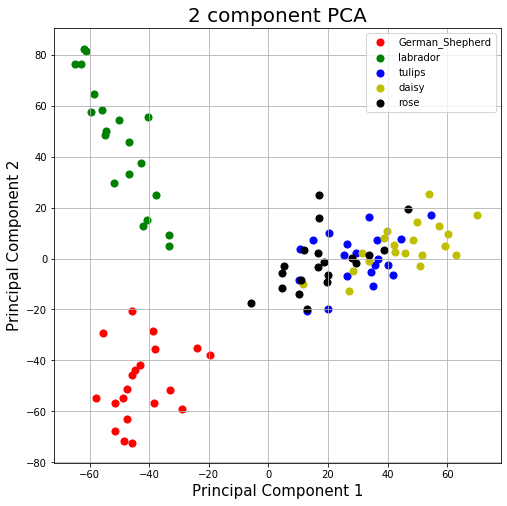

In [30]:
#your code here
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = listGroupsPCA
colors = ['r', 'g', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = pca_sample['group'] == target
    ax.scatter(pca_sample.loc[indicesToKeep, 'principal component 1']
               , pca_sample.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Make some comments

#### Your comments here:


The distinction between the feature maps for the dogs are very clear but the feature maps for the flowers are unclear, all overlapping with each other. This make sense because at this stage, the mobilenet base model might not have seen much (or any) flower types so they don't have the ability to classify these images. However, they might have been well trained to classify the dogs, so the feature maps can map the feature of labrador and german shepherd pretty accurately.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1.3
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>good job
</span></div></div>

<div class='exercise'><b> Question 2: Improve the classification ability of the pre-trained MobileNet  [30pts total] </b></div>



How can we improve the MobileNet?

The pre-trained MobileNet architecture shows quite good performance. Nevertheless, we want to improve  its classification ability  on the class of flowers. 
Training the MobileNet from  scratch by using only images  for dogs and flowers  will be overfitting because our dataset is too small and the network very expressive. So, let's use *transfer learning*.

 Use the pre-trained model and re-train just a few layers (fast and efficient).
 Since the convolution layers of the MobileNet can extract  abstract features from the images we can use (transfer) this knowledge by  freezing the convolution pre-trained layers. In particular, we can adjust and train one or a few new layers to classify the new data from the extracted features


**2.1. [15pts] Add and train a new dense layer on the top of the pre-trained MobileNet**


Use all the pre-trained convolution layers obtained by MobileNet (`base` model) and adjust one new dense layer in the end (`head`). Then, freeze the base layers and train only the fully connected layer. 

Define the base model

In [31]:
#your code here
base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
base_model.trainable = False

Create the new architecture by transfering the convolutions layers from the MobileNet. The name of the new architecture should be  `mobile_tl`.


In [44]:
#your code here
from tensorflow.keras.layers import Dropout

mobile_tl = tf.keras.Sequential([
    base_model,
    #Conv2D(filters=64, kernel_size=(3,3),padding='same', activation="relu"),
    GlobalAveragePooling2D(),
    #Conv2D(filters=64, kernel_size=(3,3),padding='same', activation="relu"),
    #MaxPooling2D((2,2), padding='same'),
    #Flatten(),
    #Dropout(0.5),
    Dense(1024,activation='relu'),
#     Dropout(0.2),
    Dense(128,activation='relu'),
    Dense(5, 
          activation='softmax', 
          kernel_regularizer=tf.keras.regularizers.l1(0.2), 
          bias_regularizer=tf.keras.regularizers.l1(0.1))
])

mobile_tl.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_10 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 4,410,309
Trainable params: 1,181,445
Non-trainable params: 3,228,864
_________________________________________________________________


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2.1
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>correct. You should have used the dropout layers though
</span></div></div>

**2.2. [15pts] Compile the model and show the perfrormance of the new model**

Define an optimizer, the loss function, regularization, and the number of training period (epochs).  
To inspect the network performance after the training, you might store the Loss functions and the accuracy.
For the specific example, the validation loss should be less than 1 and the accuracy on the validation set should be at least 80%. A training between five and ten epochs should be fine.


In [38]:
# listGroupsTrain

In [45]:
#your code here

optimizer = Adam(0.001)
metrics = ['accuracy'] 
loss = tf.keras.losses.categorical_crossentropy

mobile_tl.compile(optimizer = optimizer, loss=loss, metrics=metrics)

epochs = 10
batch_size = 32
#steps_per_epoch = np.ceil(train_generator.n / batch_size)
#test_steps = np.ceil(test_generator.n / batch_size)

history = mobile_tl.fit_generator(generator=train_generator, epochs=epochs, #steps_per_epoch = steps_per_epoch,
                                  validation_data=test_generator,) #validation_steps=test_steps)
                                 

Epoch 1/10
27/27 [==============================] - 21s 791ms/step - loss: 12.7553 - accuracy: 0.6868 - val_loss: 11.4524 - val_accuracy: 0.5769
Epoch 2/10
27/27 [==============================] - 20s 734ms/step - loss: 9.4702 - accuracy: 0.8660 - val_loss: 8.5336 - val_accuracy: 0.6538
Epoch 3/10
27/27 [==============================] - 21s 759ms/step - loss: 7.0842 - accuracy: 0.8719 - val_loss: 6.0880 - val_accuracy: 0.8077
Epoch 4/10
27/27 [==============================] - 19s 701ms/step - loss: 4.9956 - accuracy: 0.9348 - val_loss: 4.3631 - val_accuracy: 0.7404
Epoch 5/10
27/27 [==============================] - 20s 732ms/step - loss: 3.4170 - accuracy: 0.9229 - val_loss: 3.0276 - val_accuracy: 0.7404
Epoch 6/10
27/27 [==============================] - 19s 699ms/step - loss: 2.2172 - accuracy: 0.9193 - val_loss: 2.0867 - val_accuracy: 0.7404
Epoch 7/10
27/27 [==============================] - 18s 684ms/step - loss: 1.3260 - accuracy: 0.9454 - val_loss: 1.3737 - val_accuracy: 0.75

In [46]:
mobile_tl.evaluate(test_generator)

4/4 [==============================] - 4s 1s/step - loss: 0.9290 - accuracy: 0.7308


[0.9289920330047607, 0.7307692]

Plot the loss and the accuracy for training and validation

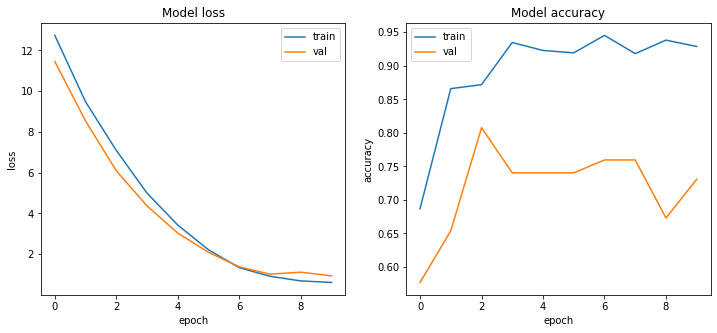

In [47]:
#your code here
fig, ax = plt.subplots(1,2,figsize=[12,5])
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='best')

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2.2
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Correct, I would expect better performance though. Maybe regularization parameters of L1,L2 are too large. For the homework purpose it is fine
</span></div></div>

<div class='exercise'><b> Question 3: Improve the extraction of the feature maps [30pts total] </b></div>


**3.1. [pts 15] Fine Tuning**

Take the previous based model and unfreeze the convolution layers. Create a new model with the base model and with the dense layer used in the `model_tl`. Then, train the entire network. Name the new model as `mobile_tuned`.

In [48]:
#your code here
base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
base_model.trainable = True

mobile_tuned = tf.keras.Sequential([
    base_model,
    #Conv2D(filters=64, kernel_size=(3,3),padding='same', activation="relu"),
    GlobalAveragePooling2D(),
    #Conv2D(filters=64, kernel_size=(3,3),padding='same', activation="relu"),
    #MaxPooling2D((2,2), padding='same'),
    #Flatten(),
    #Dropout(0.5),
    Dense(1024,activation='relu'),
#     Dropout(0.3),
    Dense(128,activation='relu'),
#     Dropout(0.3),
    Dense(5, 
          activation='softmax', 
          kernel_regularizer=tf.keras.regularizers.l1(0.2), 
          bias_regularizer=tf.keras.regularizers.l1(0.1))
])

mobile_tuned.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_13 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 645       
Total params: 4,410,309
Trainable params: 4,388,421
Non-trainable params: 21,888
_________________________________________________________________


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q3.1
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>This is the fine-tuning part that means you need to use the dense layers that you use in the Q2. But you  define new layers with which are untrained
</span></div><div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-10</span></div></div>

**3.2. [15pts] Compile the model, present the perfrormance of the new model, and visualize the feature maps with PCA**


In [49]:
#your code here

optimizer = Adam(lr=0.001)
metrics = ['accuracy'] 
loss = tf.keras.losses.CategoricalCrossentropy()

mobile_tuned.compile(optimizer = optimizer, loss=loss, metrics=metrics)

epochs = 10
batch_size = 32
# steps_per_epoch = np.ceil(train_generator.n / batch_size)
# test_steps = np.ceil(test_generator.n / batch_size)

history_tuned = mobile_tuned.fit_generator(generator=train_generator,
#                                            steps_per_epoch = steps_per_epoch,
                                           epochs=epochs,
                                           validation_data=test_generator,)
#                                            validation_steps=test_steps)

Epoch 1/10
27/27 [==============================] - 22s 822ms/step - loss: 12.8423 - accuracy: 0.7568 - val_loss: 14.4024 - val_accuracy: 0.5385
Epoch 2/10
27/27 [==============================] - 22s 805ms/step - loss: 9.7277 - accuracy: 0.8541 - val_loss: 14.1866 - val_accuracy: 0.2692
Epoch 3/10
27/27 [==============================] - 18s 684ms/step - loss: 7.1274 - accuracy: 0.9122 - val_loss: 7.6349 - val_accuracy: 0.5962
Epoch 4/10
27/27 [==============================] - 20s 754ms/step - loss: 5.0150 - accuracy: 0.9265 - val_loss: 5.3893 - val_accuracy: 0.6154
Epoch 5/10
27/27 [==============================] - 19s 709ms/step - loss: 3.1825 - accuracy: 0.9644 - val_loss: 3.1477 - val_accuracy: 0.6731
Epoch 6/10
27/27 [==============================] - 19s 712ms/step - loss: 1.8575 - accuracy: 0.9502 - val_loss: 1.7382 - val_accuracy: 0.7308
Epoch 7/10
27/27 [==============================] - 19s 697ms/step - loss: 0.9429 - accuracy: 0.9502 - val_loss: 0.7524 - val_accuracy: 0.9

Visualize the performance (in comparison with the `mobile_tl`) and make some comments

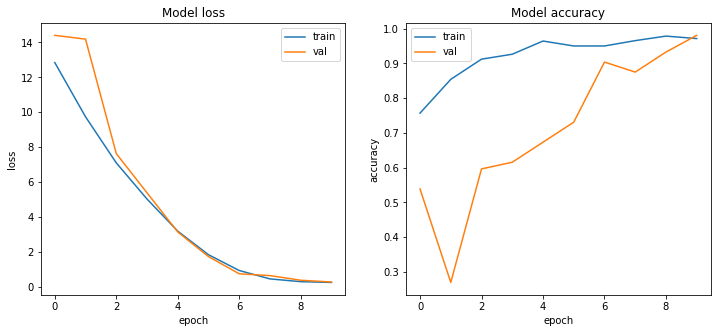

In [50]:
#your code here

fig, ax = plt.subplots(1,2,figsize=[12,5])
ax[0].plot(history_tuned.history['loss'])
ax[0].plot(history_tuned.history['val_loss'])
ax[0].set_title('Model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(history_tuned.history['accuracy'])
ax[1].plot(history_tuned.history['val_accuracy'])
ax[1].set_title('Model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='best')

#### Your comments here:

After the fine-tuning we observe that the training is improved. Namely, the loss descreases and the accuracy increases when we trained the entire network.

**Investigate the feature extraction by using PCA**


Visualize the results obtained by PCA

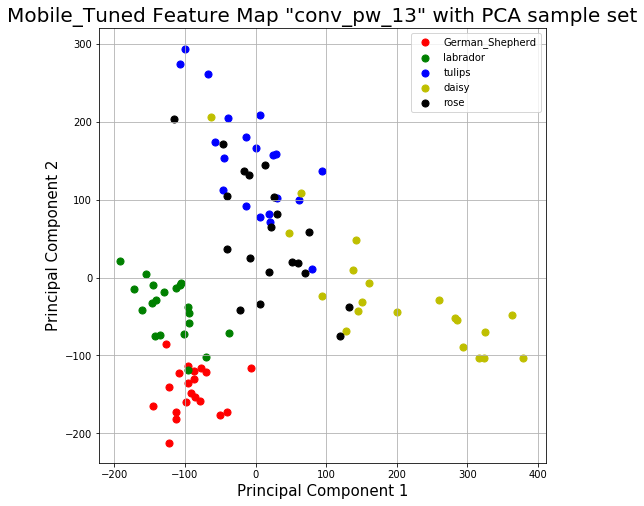

In [51]:
layer_dict = dict([(layer.name, layer) for layer in mobile_tuned.layers[0].layers]) #layer 0 in mobile_tuned is the base model (mobilenet)
layer_name = 'conv_pw_13'
layer = list(layer_dict.keys()).index(layer_name)

pathPCA = pathFolder + 'pcaData/'
listGroupsPCA = filter_hidden(os.listdir(pathPCA)) # the directory path
images = {}
X_pca = pd.DataFrame([])
for i in listGroupsPCA:
    path_images = pathPCA + i + '/'
    images[i] = filter_hidden(os.listdir(path_images))

    for j in images[i]:
        x = pd.Series(get_feature_maps(mobile_tuned.layers[0], layer, prepare_image(path_images+j)[0]).flatten(),name=i)
        X_pca = X_pca.append(x)

X_pca = X_pca.reset_index()
X_pca = X_pca.rename(columns = {'index':'group'})

model_pca = PCA(2).fit(X_pca.drop('group',axis=1))
pca_sample = pd.DataFrame(model_pca.transform(X_pca.drop('group',axis=1)), columns = ['principal component 1', 'principal component 2'])
pca_sample = pd.concat([pca_sample, X_pca['group']], axis = 1)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Mobile_Tuned Feature Map "conv_pw_13" with PCA sample set', fontsize = 20)
targets = listGroupsPCA
colors = ['r', 'g', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = pca_sample['group'] == target
    ax.scatter(pca_sample.loc[indicesToKeep, 'principal component 1']
               , pca_sample.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [52]:

# visulatization of the test set 
listGroupsTest = filter_hidden(os.listdir(pathTest)) # the directory path
images = {}
X_test = pd.DataFrame([])
for i in listGroupsTest:
    path_images = pathTest + i + '/'
    images[i] = filter_hidden(os.listdir(path_images))

    for j in images[i]:
        x = pd.Series(mobile_tuned.predict(prepare_image(path_images+j)).flatten(),name=i)
        X_test = X_test.append(x)

X_test = X_test.reset_index()
X_test = X_test.rename(columns = {'index':'group'})

model_pca = PCA(2).fit(X_test.drop('group',axis=1))
pca_test = pd.DataFrame(model_pca.transform(X_test.drop('group',axis=1)), columns = ['principal component 1', 'principal component 2'])
pca_test = pd.concat([pca_test, X_test['group']], axis = 1)


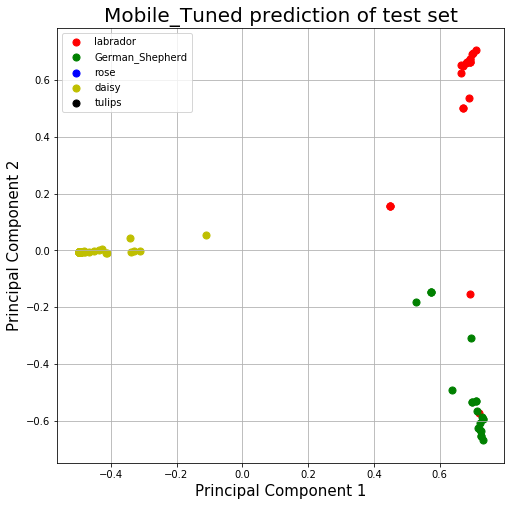

In [53]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Mobile_Tuned prediction of test set', fontsize = 20)
targets = listGroupsTest
colors = ['r', 'g', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = pca_test['group'] == target
    ax.scatter(pca_test.loc[indicesToKeep, 'principal component 1']
               , pca_test.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

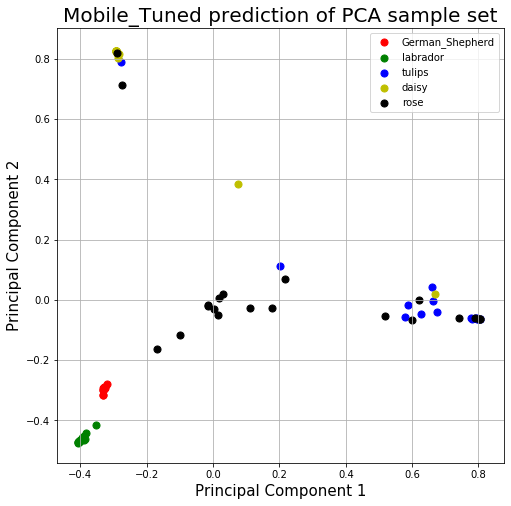

In [54]:
#your code here

pathPCA = pathFolder + 'pcaData/'
listGroupsPCA = filter_hidden(os.listdir(pathPCA)) # the directory path
images = {}
X_pca = pd.DataFrame([])
# totalImages = 0
for i in listGroupsPCA:
    path_images = pathPCA + i + '/'
    images[i] = filter_hidden(os.listdir(path_images))

    for j in images[i]:
        x = pd.Series(mobile_tuned.predict(prepare_image(path_images+j)).flatten(),name=i)
        X_pca = X_pca.append(x)
# print('Total number of images: {}'.format(totalImages))

X_pca = X_pca.reset_index()
X_pca = X_pca.rename(columns = {'index':'group'})

model_pca = PCA(2).fit(X_pca.drop('group',axis=1))
pca_sample = pd.DataFrame(model_pca.transform(X_pca.drop('group',axis=1)), columns = ['principal component 1', 'principal component 2'])
pca_sample = pd.concat([pca_sample, X_pca['group']], axis = 1)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Mobile_Tuned prediction of PCA sample set', fontsize = 20)
targets = listGroupsPCA
colors = ['r', 'g', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = pca_sample['group'] == target
    ax.scatter(pca_sample.loc[indicesToKeep, 'principal component 1']
               , pca_sample.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Make some comments

#### Your comments here:


The feature map of the last convolution layer in `mobile_tuned`, namely layer `conv_pw_13` in the base layer (mobilenet) that has been fine tuned, we can see the clearer boundaries between the different categories. Like in Q1.3, the dogs and the flowers are separated (dogs on the left, flowers more on the right) and the 2 types of dogs (german shepherd and labrador) are well separated as well. However, while in Q1.3 the 3 types of flowers (daisy, rose, tulips) are all lumped together, here we see the daisy, rose, and tulips are more sparsely positioned in the PCA plots (although there still exists some overlaps), and thus can be better distinguished one from the other then with the original mobilenet model. 

The predictions that `mobile_tuned` has for the dogs and the flowers has a pretty clear boundaries as well. Within the dogs category, labrador and German_Shepherd are clearly separated one from the other (clear boundaries from the PCA plot), however the prediction for the flowers (Daisy, tulips and roses) are a little overlapping.


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q3.2
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Indeed in the PCA graph the cluster separation is better. However, you are not doing fine-tuning since you train from scratch the dense layers, that's why you dont observe very good performance in the validation accuracy
</span></div><div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-10</span></div></div>

## **References**

- https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299
- https://towardsdatascience.com/review-mobilenetv1-depthwise-separable-convolution-light-weight-model-a382df364b69
- https://www.alibabacloud.com/blog/part-3-image-classification-using-features-extracted-by-transfer-learning-in-keras_595291
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://arxiv.org/abs/1704.04861    



<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Graded by: Marios Matthaiakis
</footer>